In [44]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torchvision

from torchvision import datasets, transforms, models
from torch import nn
from torch import optim



from PIL import Image

from facenet_pytorch import MTCNN
import cv2
from PIL import Image
from matplotlib import pyplot as plt

from facenet_pytorch import InceptionResnetV1

## Load the data

Here we use `torchvision` to load the data. The dataset is split into three parts, training, validation, and testing. For the training, we want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize, leading to better performance. We also need to make sure the input data is resized to 160x160 pixels as required by the pre-trained network.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we need to resize and crop the images to the appropriate size.

In [2]:
data_dir = 'faces_split'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
images_transforms = {}
RGB_MEAN = [ 0.485, 0.456, 0.406 ]
RGB_STD = [ 0.229, 0.224, 0.225 ]

images_transforms['training'] = transforms.Compose([transforms.Resize(160),
                                                    transforms.RandomRotation(34),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(RGB_MEAN, RGB_STD)])

images_transforms['testing'] = transforms.Compose([transforms.Resize(160),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(RGB_MEAN, RGB_STD)])

images_transforms['validation'] =  transforms.Compose([transforms.Resize(160),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize(RGB_MEAN, RGB_STD),])

# TODO: Load the datasets with ImageFolder
images_data = {}
images_data['training'] = datasets.ImageFolder(train_dir, transform=images_transforms['training'])
images_data['testing'] = datasets.ImageFolder(test_dir, transform=images_transforms['testing'])
images_data['validation'] = datasets.ImageFolder(valid_dir, transform=images_transforms['validation'])

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {}

dataloaders['training'] = torch.utils.data.DataLoader(images_data['training'], batch_size=22, shuffle=True)
dataloaders['testing'] = torch.utils.data.DataLoader(images_data['testing'], batch_size=22)
dataloaders['validation'] = torch.utils.data.DataLoader(images_data['validation'], batch_size=22)

### Label mapping

We also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`.. This will give us a dictionary mapping the integer encoded categories to the actual names of the people.

In [4]:
import json

with open(data_dir + '/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)

{'1': 'Alex', '2': 'Henry', '3': 'Jama', '4': 'Kacper', '5': 'Kumud', '6': 'Raghad', '7': 'Robert', '8': 'Ubaid', '9': 'Kiyong'}


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. We use one of the pretrained models from to get the image features.

In [5]:
# TODO: Build and train your network

In [6]:
class NewClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8631, 8000)
        self.fc2 = nn.Linear(8000, 7200)
        self.fc3 = nn.Linear(7200, 6500)
        self.fc4 = nn.Linear(6500, 4300)
        self.fc5 = nn.Linear(4300, 2600)
        self.fc6 = nn.Linear(2600, 1200)
        self.fc7 = nn.Linear(1200, 1000)
        self.fc8 = nn.Linear(1000, 500)
        self.fc9 = nn.Linear(500, 16)
        self.out_layer = nn.Linear(16, 9)

        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        x = self.dropout(F.relu(self.fc6(x)))
        x = self.dropout(F.relu(self.fc7(x)))
        x = self.dropout(F.relu(self.fc8(x)))
        x = self.dropout(F.relu(self.fc9(x)))

        x = F.log_softmax(self.out_layer(x), dim=1)

        return x

In [7]:
# help(InceptionResnetV1)
# For a model pretrained on VGGFace2
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=9)

for param in model.parameters():
    param.requires_grad = True
    
model.classifier = NewClassifier()

In [8]:
criterion = nn.NLLLoss()
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.8)
epochs = 3
running_loss = 0

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# print(device)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [10]:
print_every = 10
training_loop = 0
for epoch in range(epochs): #for each epoch
    running_loss = 0
    for images_train, labels_train in dataloaders['training']: #for each batch in training data loader
        images_train, labels_train = images_train.to(device), labels_train.to(device)
        #--------------------------------------------------- TRAINING ----------------
        #reset gradients on optimizer
        optimizer.zero_grad() 
        #feedforward
        log_ps = model.forward(images_train)
        #loss and gradients calculation
        loss = criterion(log_ps, labels_train)
        loss.backward()
        #updating weights
        optimizer.step()
        #adding batch loss to total loss
        running_loss += loss.item()
        training_loop +=1
        #--------------------------------------------------- VALIDATION ----------------
        if training_loop  % print_every == 0:
            #setting evaluation mode (dropout off)
            model.eval()
            valid_loss = 0
            accuracy = 0
            #disabling gradients (useless gradients here, code runs faster)
            with torch.no_grad():
                for images_valid, labels_valid in dataloaders['validation']: #fetching validation data
                    images_valid, labels_valid = images_valid.to(device), labels_valid.to(device)
                    #Loss Calculation
                    log_ps = model.forward(images_valid)
                    batch_loss = criterion(log_ps, labels_valid)
                    valid_loss += batch_loss.item()
                    #Accuracy Calculation
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels_valid.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            #setting training mode again (end of evaluation)       
            model.train()
            #print statement
            print(f"Epoch {epoch+1} of {epochs}: "
                  f"Train loss: {(running_loss/print_every):.5f} -> "
                  f"Validation loss: {valid_loss/len(dataloaders['validation']):.5f} -> "
                  f"Validation accuracy: {accuracy/len(dataloaders['validation']):.3f}")
            running_loss = 0
            #End Torch No_grad
        #End if (End validation)
    #print statement for the epoch
    print(f" END OF EPOCH {epoch+1} of {epochs}.. ")
    #End epoch

Epoch 1 of 3: Train loss: -0.03335 -> Validation loss: -0.13638 -> Validation accuracy: 0.109
Epoch 1 of 3: Train loss: -0.29464 -> Validation loss: -0.42692 -> Validation accuracy: 0.321
Epoch 1 of 3: Train loss: -0.58746 -> Validation loss: -0.76165 -> Validation accuracy: 0.548
Epoch 1 of 3: Train loss: -0.86232 -> Validation loss: -1.09922 -> Validation accuracy: 0.672
Epoch 1 of 3: Train loss: -1.15106 -> Validation loss: -1.41835 -> Validation accuracy: 0.826
Epoch 1 of 3: Train loss: -1.50433 -> Validation loss: -1.75507 -> Validation accuracy: 0.889
Epoch 1 of 3: Train loss: -1.78896 -> Validation loss: -2.10812 -> Validation accuracy: 0.907
Epoch 1 of 3: Train loss: -2.00239 -> Validation loss: -2.39394 -> Validation accuracy: 0.927
 END OF EPOCH 1 of 3.. 
Epoch 2 of 3: Train loss: -0.51680 -> Validation loss: -2.73562 -> Validation accuracy: 0.947
Epoch 2 of 3: Train loss: -2.55600 -> Validation loss: -3.04054 -> Validation accuracy: 0.960
Epoch 2 of 3: Train loss: -2.93706 -

## Testing the network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images.

In [11]:
# TODO: Do validation on the test set

#setting evaluation mode (dropout off)
model.eval()
test_loss = 0
accuracy = 0
#disabling gradients (useless gradients here, code runs faster)
with torch.no_grad():
    for images_test, labels_test in dataloaders['testing']: #fetching validation data
        images_test, labels_test = images_test.to(device), labels_test.to(device)
        #Loss Calculation
        log_ps = model.forward(images_test)
        batch_loss = criterion(log_ps, labels_test)
        test_loss += batch_loss.item()
        #Accuracy Calculation
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels_test.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
#setting training mode again (end of evaluation)       
model.train()
#print statement
print(f"Test accuracy: {accuracy/len(dataloaders['testing']):.3f}")

Test accuracy: 1.000


## Save the checkpoint

Now that your network is trained, we save the model so that we can load it later for making predictions. we want to save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. we attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

In [47]:
# TODO: Save the checkpoint
checkpoint = {
                'pre_trained_network': 'vggface2',
                'num_classes': 9,
                'model_state_dict': model.state_dict(),
                'classifier': model.classifier,
                'classifier_state_dict': model.classifier.state_dict(),
                'optimizer': optimizer.state_dict(),
                'class_to_idx': images_data['training'].class_to_idx,
                'learning_rate': 0.0001,
                'epochs': epochs
              }

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [48]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    model = InceptionResnetV1(pretrained=checkpoint['pre_trained_network'], classify=True, num_classes=checkpoint['num_classes']) # models.vggface2(pretrained=True)

    
    classifier = model.classifier = checkpoint['classifier']
    classifier.load_state_dict(checkpoint['classifier_state_dict'])
    
    model.load_state_dict(checkpoint['model_state_dict'])


    model.class_to_idx = checkpoint['class_to_idx']
    epochs = checkpoint['epochs']

    optimizer.load_state_dict(checkpoint['optimizer'])
    
    return model

In [49]:
loaded_model = load_checkpoint('checkpoint.pth')

# Inference for classification

Now we write a function to use the trained network for inference. That is, we'll pass an image into the network and predict the class of the face in the image. We write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

First we need to handle processing the input image such that it can be used in the network. 

## Image Preprocessing

we want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 160 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 160x160 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. we need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. we want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. we can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [50]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    #transforms.CenterCrop(224),
    
    # TODO: Process a PIL image for use in a PyTorch model
    transform = transforms.Compose([
                                    transforms.Resize(160),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225]
                                                        )
                                   ])
    transformed_image = np.array(transform(Image.open(image)))
    #return transformed_image.transpose((2, 0, 1))
    return transformed_image

In [51]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once we get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. we want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor we use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. we need to convert from these indices to the actual class labels using `class_to_idx` which we added to the model from the checkpoint ([see here](#Save-the-checkpoint)). 

this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

In [56]:
print(model)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [57]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    
    #loading and processing image (Transformation and tensor creation)
    #if device == 'cpu':
    image_to_predict = torch.from_numpy(process_image(image_path)).type(torch.FloatTensor)
#     else:
#         image_to_predict= torch.from_numpy(process_image(image_path)).type(torch.cuda.FloatTensor)
    image_to_predict = image_to_predict.unsqueeze_(0)
    model.to('cpu')
    image_to_predict.to('cpu')
    #settimg model evaluation mode (dropout off)
    model.eval()
    #disabling gradients: faster code
    with torch.no_grad():
        #feedforward in the network: fetching results (prediction)
        prediction = model.forward(image_to_predict)
        probabilities = torch.exp(prediction)
        top_ps= probabilities.topk(topk)[0].cpu().numpy()[0]
        top_classes_indexes = probabilities.topk(topk)[1].cpu().numpy()[0]
        #mapping class indexes to class labels
        idx_to_class= {x: y for y, x in model.class_to_idx.items()}
        top_classes_labels = []
        for clss in top_classes_indexes:
            top_classes_labels.append(idx_to_class[clss])
    #setting mode to the original one
    model.train()
    return top_ps, top_classes_labels

In [58]:
image_path = data_dir + '/test' + '/1/' + 'Face_Alex_113.jpg'
# image_path = data_dir + '/test' + '/2/' + 'Face_Henry_116.jpg' 
# image_path = data_dir + '/test' + '/5/' + 'Face_Kumud_107.jpg'
# image_path = data_dir + '/test' + '/7/' + 'Face_Robert_10.jpg'
# image_path = data_dir + '/test' + '/9/' + 'Face_Kiyong_129.jpg'
top_ps, top_classes = predict(image_path, loaded_model)

## Sanity Checking

Now that we can use a trained model for predictions, we check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. we use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

we can convert from the class integer encoding to actual face names with the `cat_to_name.json` file.

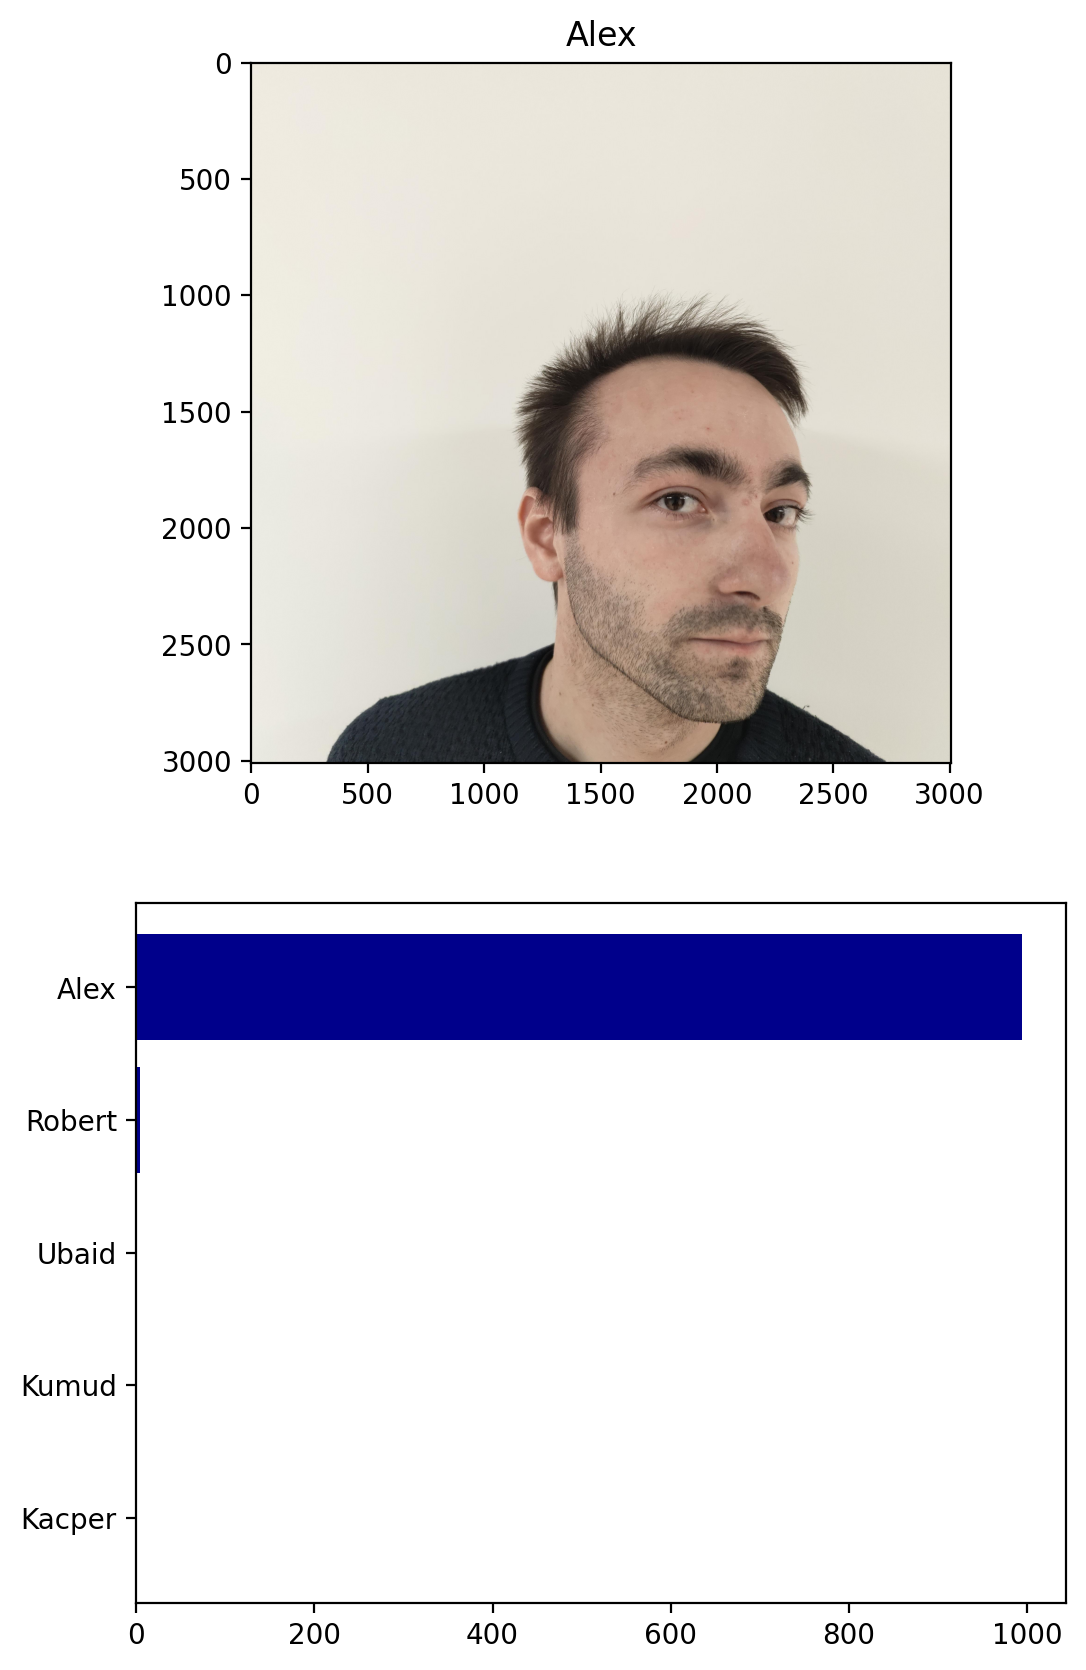

In [59]:
# TODO: Display an image along with the top 5 classes

#Getting categories names by class labels
category_names = []
for i in top_classes:
    category_names += [cat_to_name[str(i)]]

# Using matplotlib in order to show the image and the ps
f, ax = plt.subplots(2,figsize = (6,10))

ax[0].imshow(Image.open(image_path)) #setting the image to predict show
ax[0].set_title(category_names[0]) #showing name of the predicted category (the highest probability (index 0))

#setting graph: blue bars with the probability of each of the categories
graph_names = np.arange(len(category_names))
ax[1].barh(graph_names, top_ps, color='darkblue')
ax[1].set_yticks(graph_names)
ax[1].set_yticklabels(category_names)
ax[1].invert_yaxis() 

plt.show() #showing previous settings

In [63]:
def show_image_and_probs(image_path):
    top_ps, top_classes = predict(image_path, loaded_model)
    #Getting categories names by class labels
    category_names = []
    for i in top_classes:
        category_names += [cat_to_name[str(i)]]

    # Using matplotlib in order to show the image and the ps
    f, ax = plt.subplots(2,figsize = (6,10))

    ax[0].imshow(Image.open(image_path)) #setting the image to predict show
    ax[0].set_title(category_names[0]) #showing name of the predicted category (the highest probability (index 0))

    #setting graph: blue bars with the probability of each of the categories
    graph_names = np.arange(len(category_names))
    ax[1].barh(graph_names, top_ps, color='darkblue')
    ax[1].set_yticks(graph_names)
    ax[1].set_yticklabels(category_names)
    ax[1].invert_yaxis() 

    plt.show() #showing previous settings

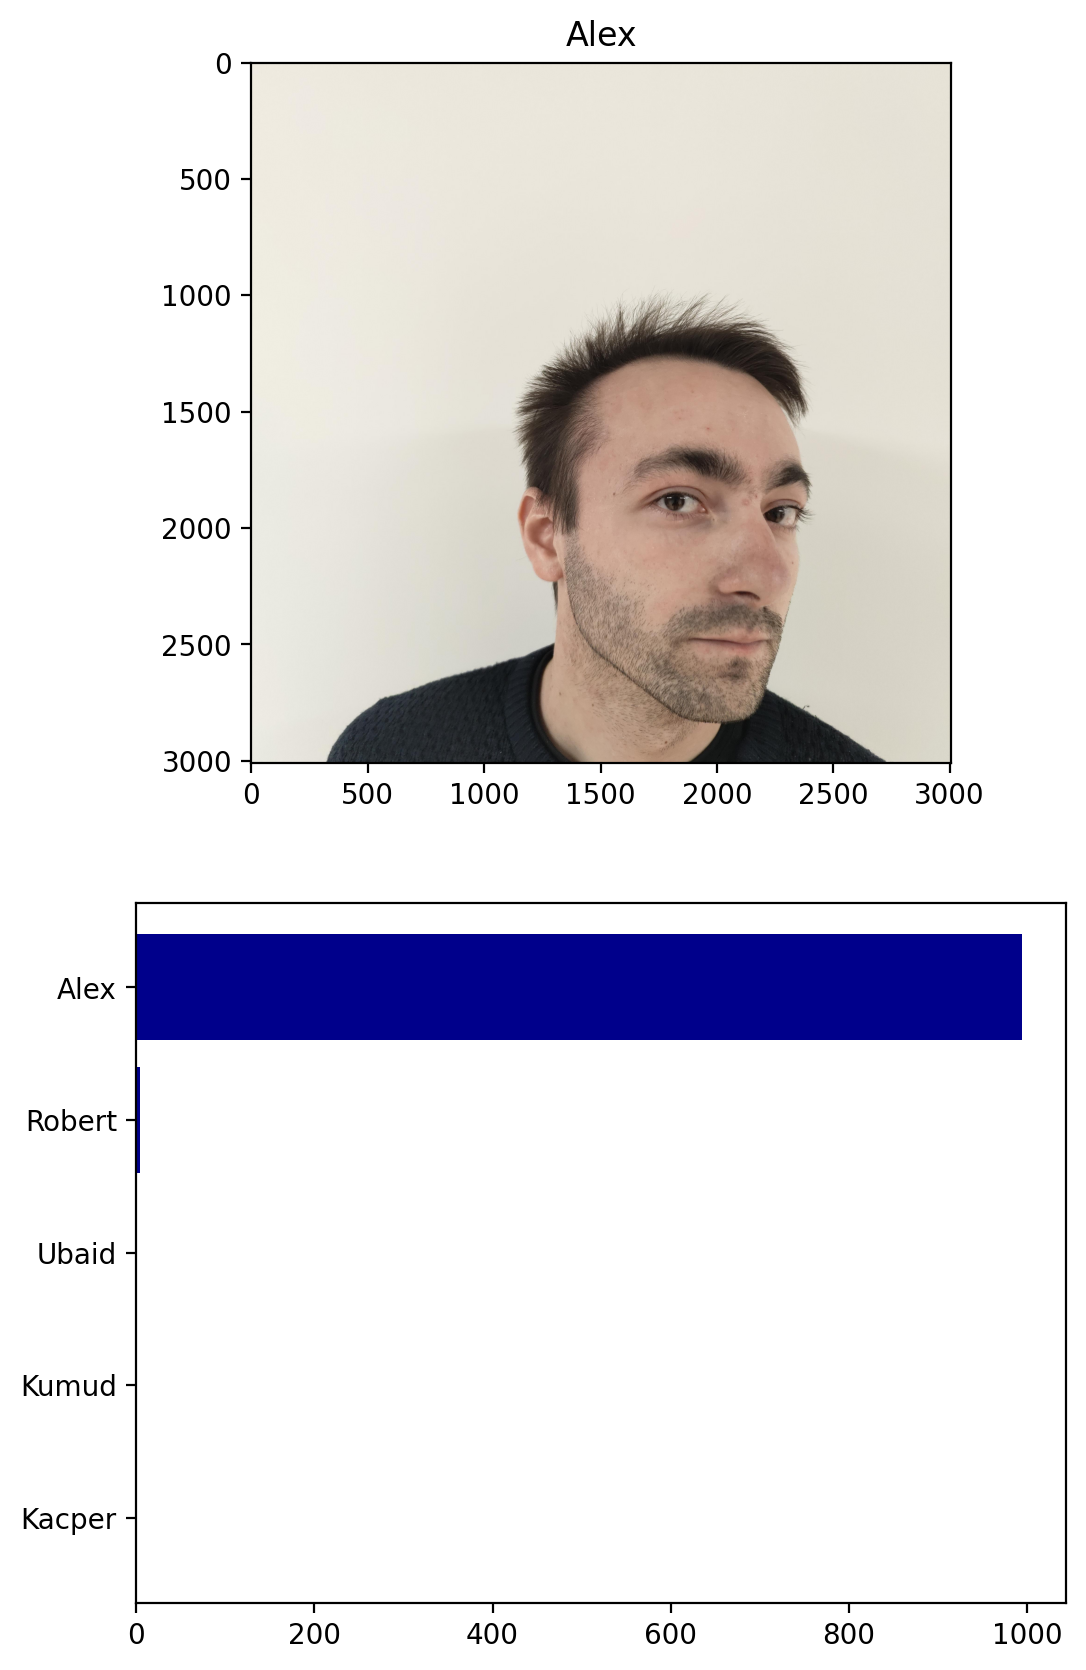

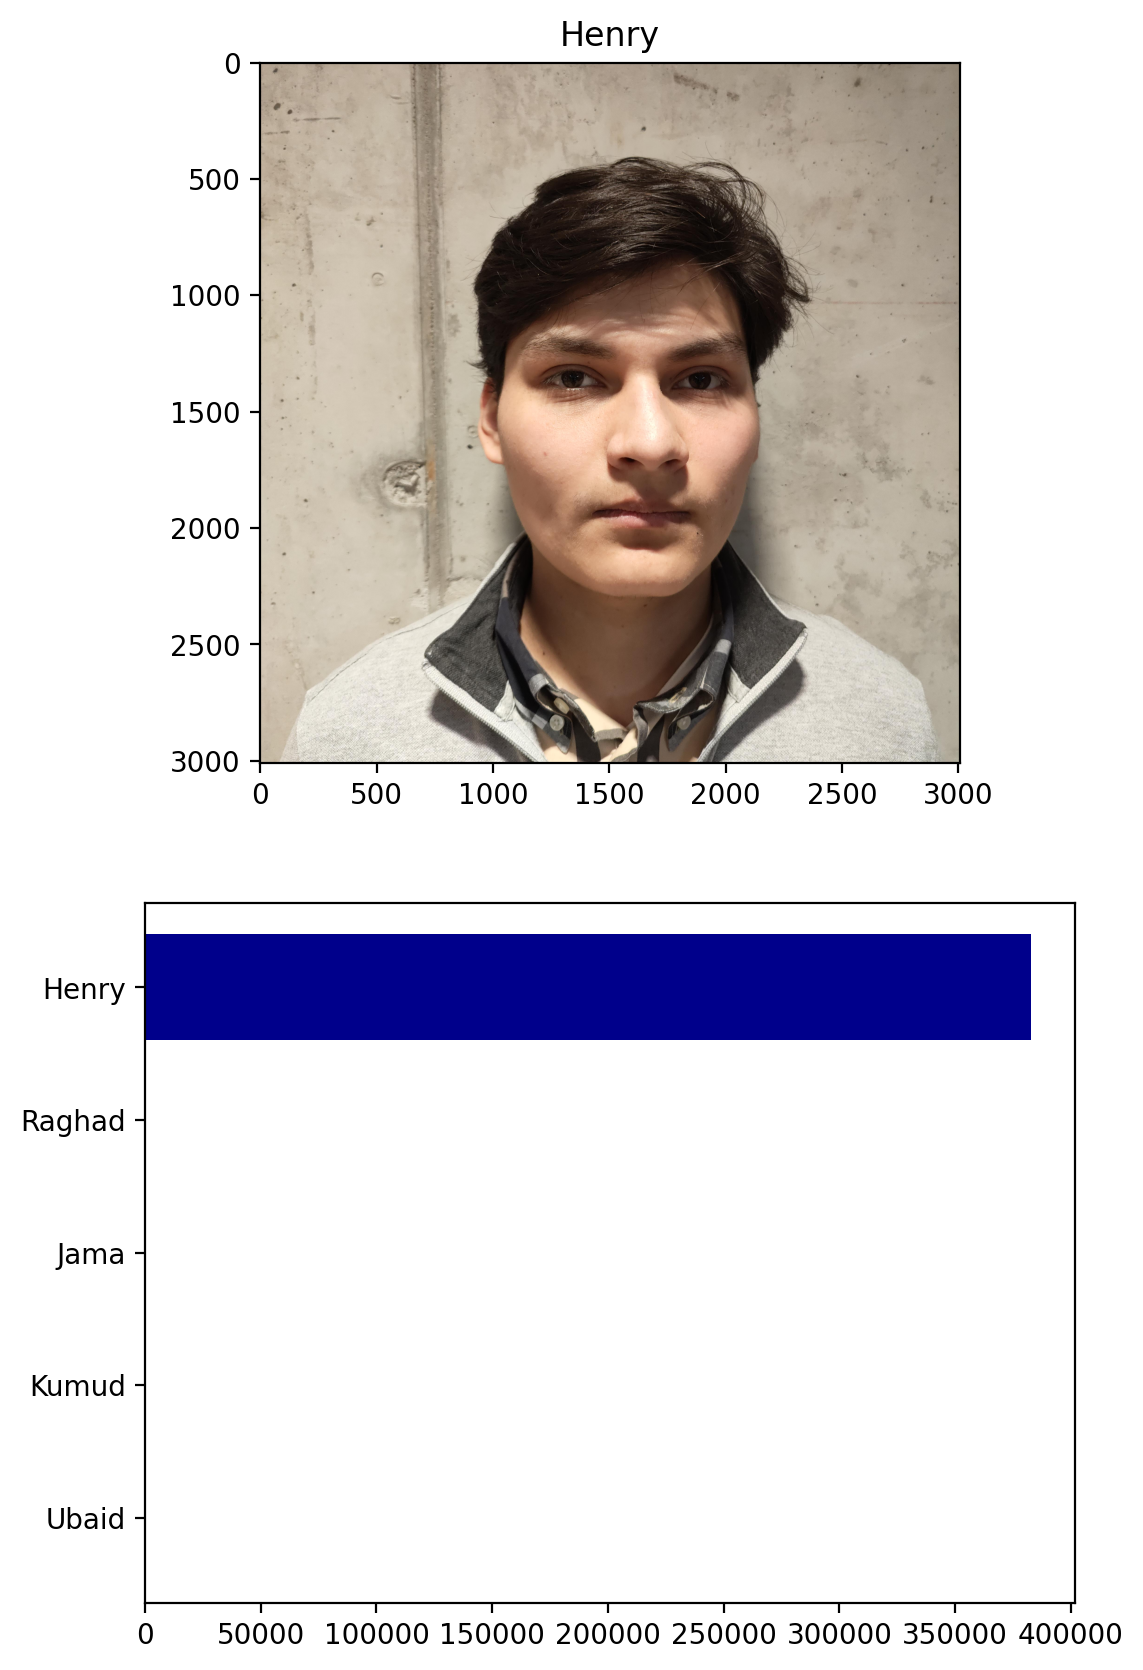

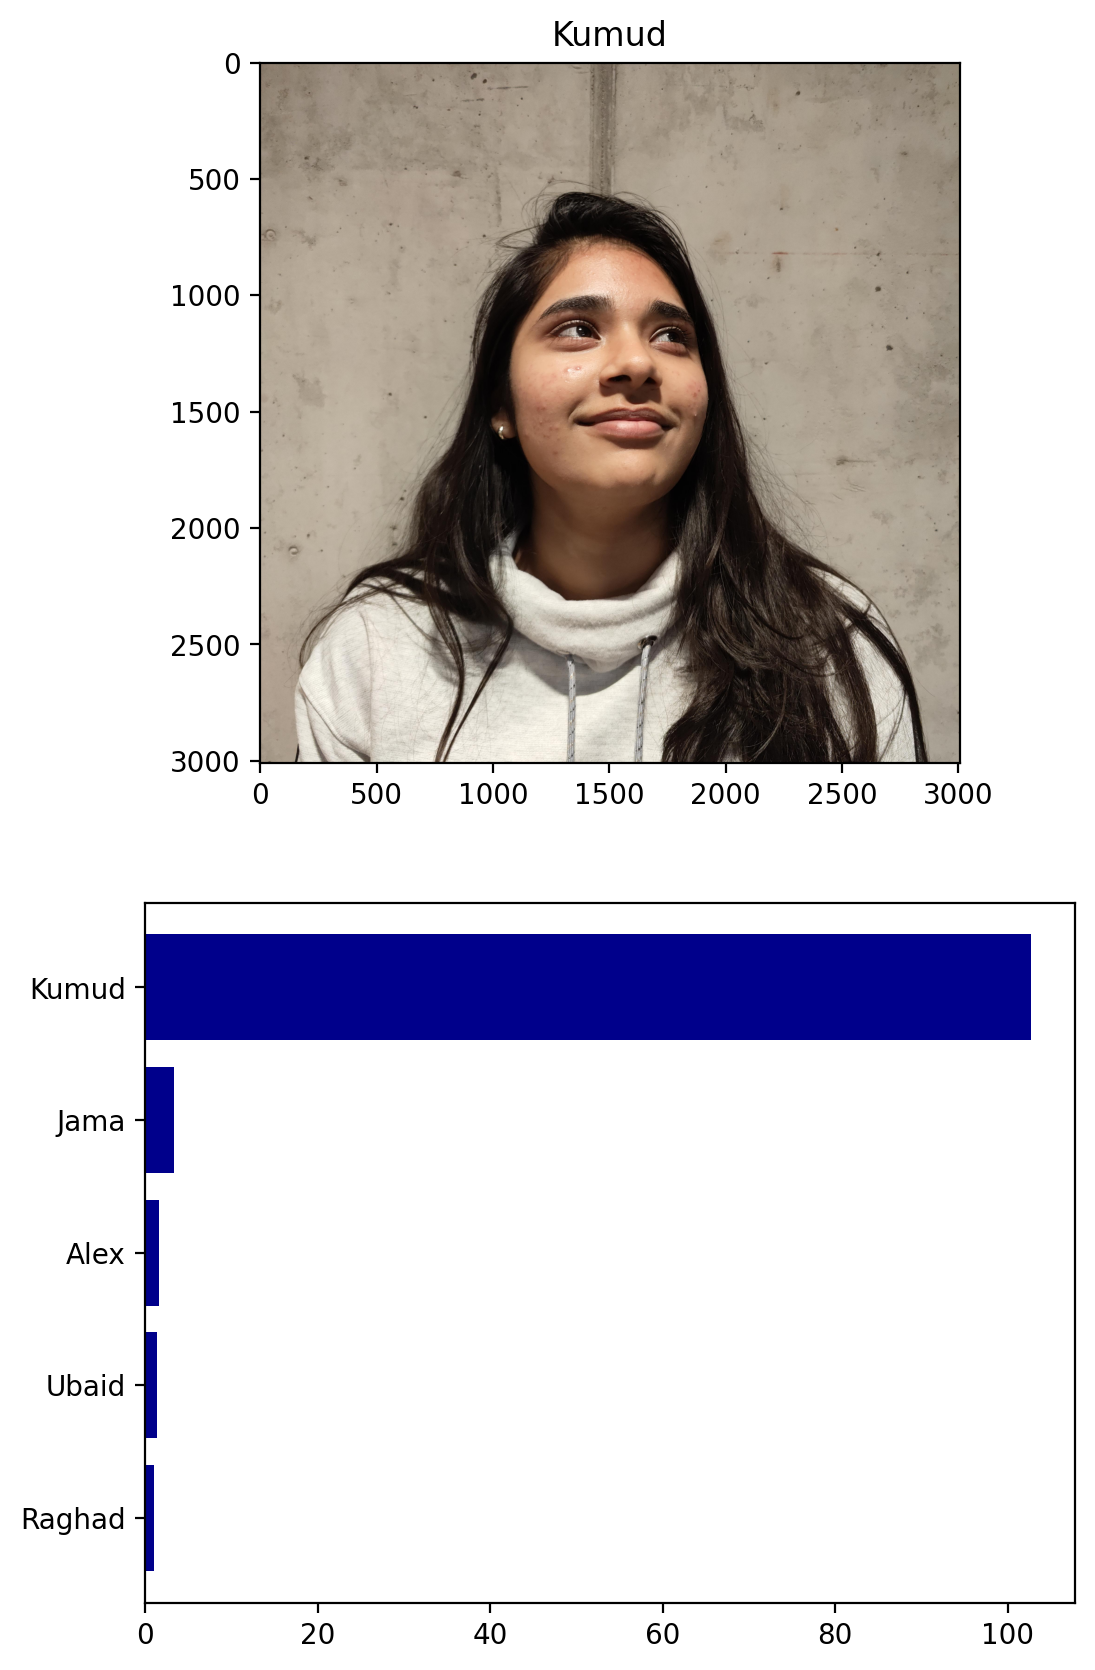

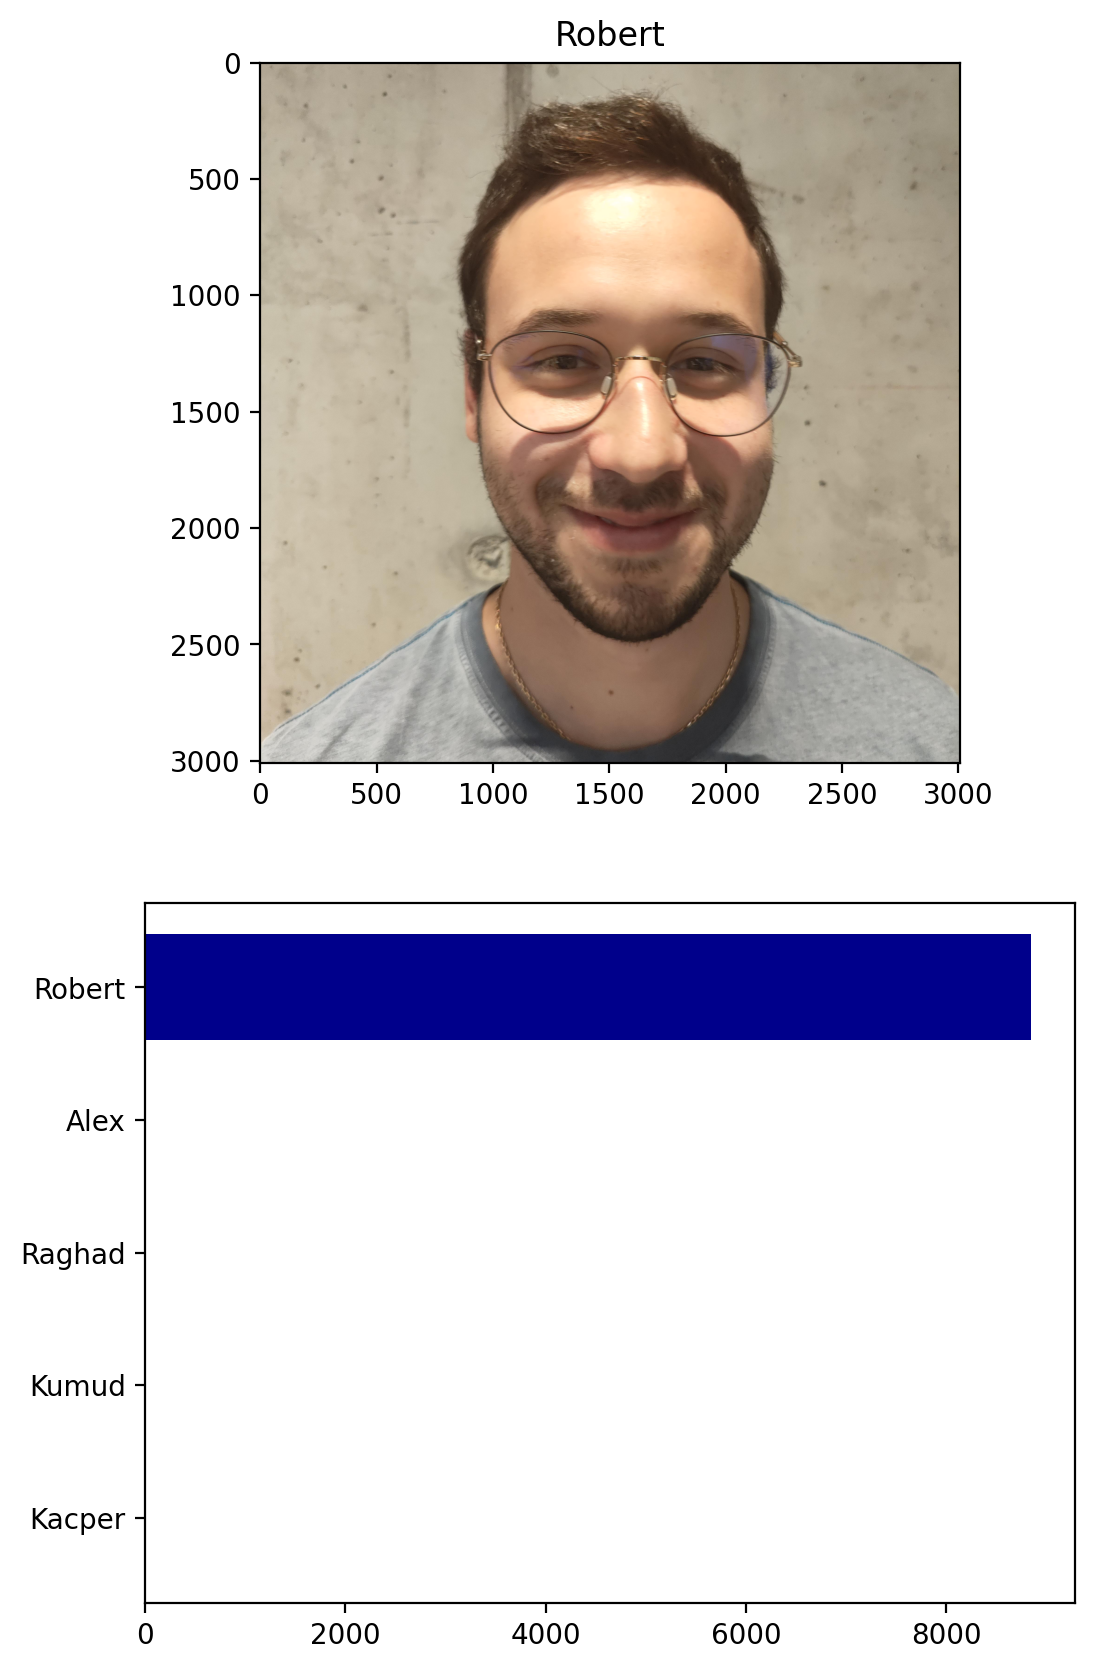

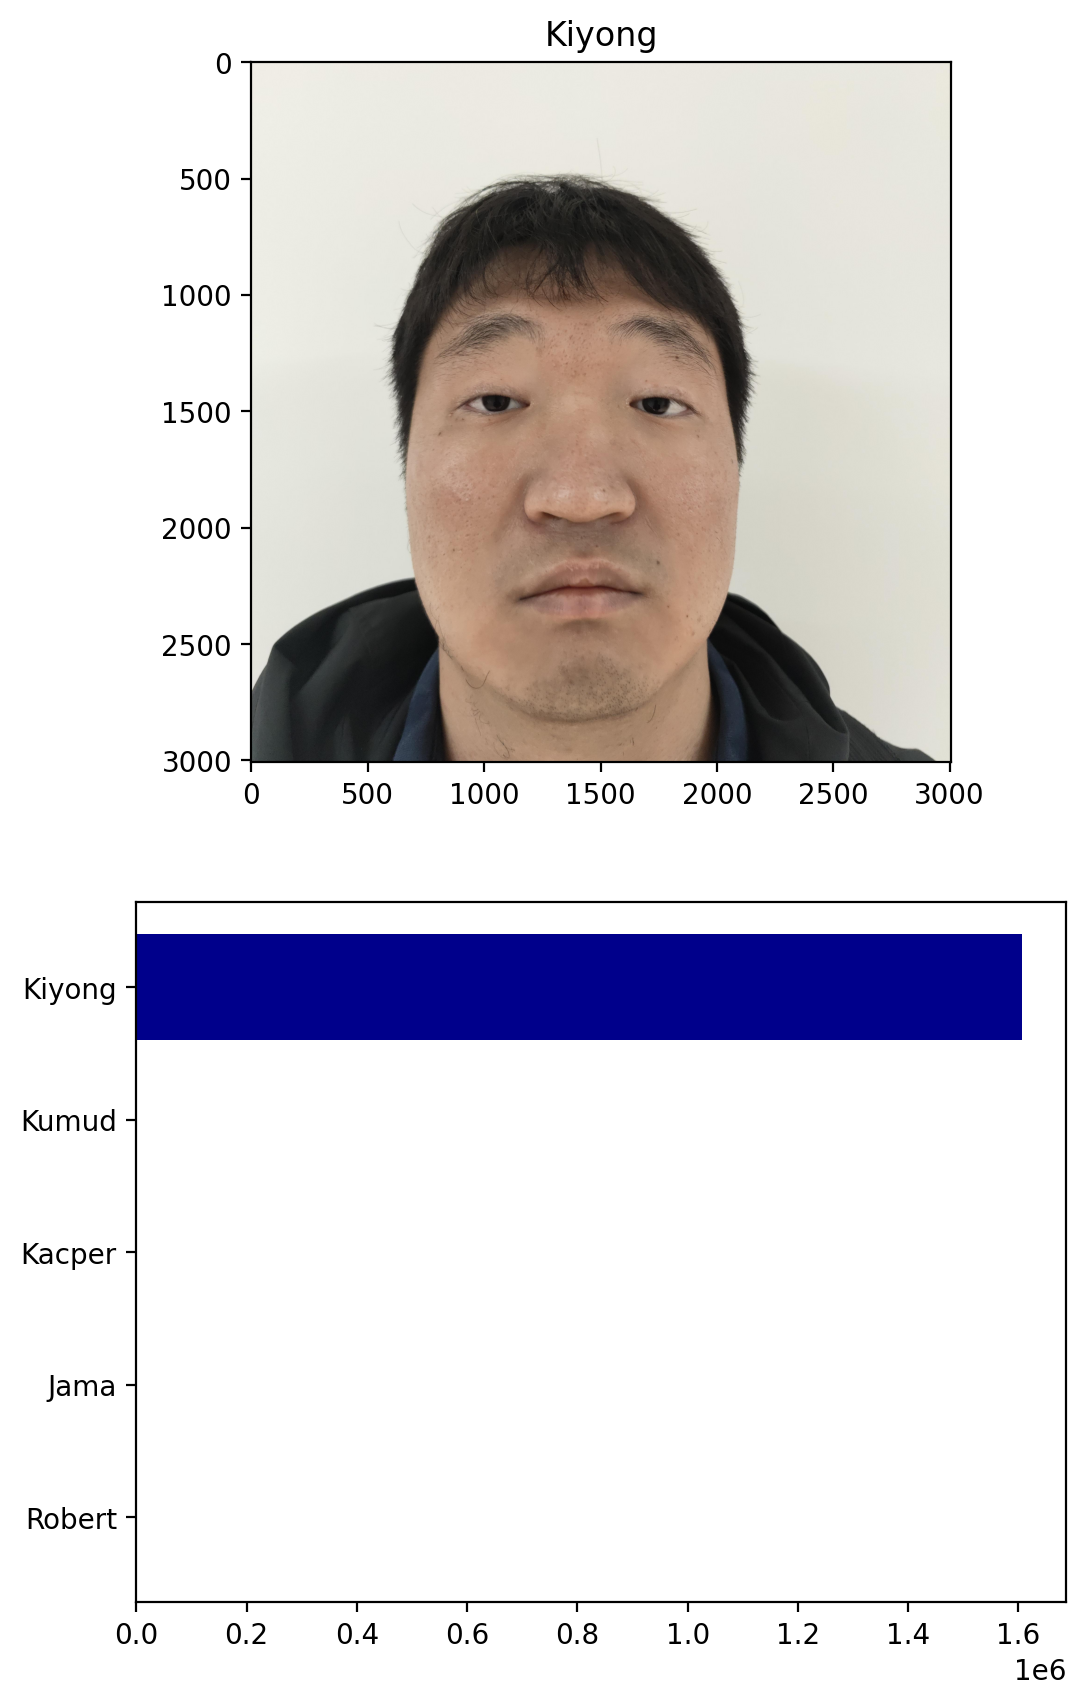

In [64]:
show_image_and_probs(data_dir + '/test' + '/1/' + 'Face_Alex_113.jpg')
show_image_and_probs(data_dir + '/test' + '/2/' + 'Face_Henry_116.jpg')
show_image_and_probs(data_dir + '/test' + '/5/' + 'Face_Kumud_107.jpg')
show_image_and_probs(data_dir + '/test' + '/7/' + 'Face_Robert_10.jpg')
show_image_and_probs(data_dir + '/test' + '/9/' + 'Face_Kiyong_129.jpg')